# Домашка №1
# Усложненная
### Эта домашка нужна для лучшего понимания, но она будет сложнее из-за использования классов и, возможно, пока непривычной форме с классами.
Абстракции в этой домашке будут очень полезны для понимания того, что происходит в торче. Эта домашка прокачает вас гораздо сильнее, но и выполнить ее будет труднее. Вам нужно будет описать несколько слоев: `Linear`, `ReLU`, `BCELoss`.  Реализация `Sigmoid` уже есть в `our_library.layers`. Реализовав слои выше вы сможете сделать n-слойную нейронную сеть с любым количеством слоев. Это получается за счет того, что вы описали всю необходимую логику:
- Как нужно обработать входные данные и передать их дальше;
- Принять градиент с последующего слоя, сделать `backward` для текущего слоя и передать градиент предыдущему слою;
- Как обновить веса, если в слоев есть обучаемые веса.

Присылайте свои недоделанные сложные домашки, пусть они не пойдут совсем в стол. Я или ассистенты посмотрят, мы обсудим и доделаем.  
Поверьте, эта домашка стоит того, чтобы ее сделать!

## Required imports

In [ ]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [ ]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [ ]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

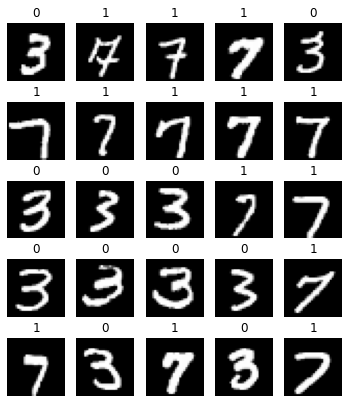

In [ ]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [ ]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [ ]:
x.shape

torch.Size([128, 1, 28, 28])

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [ ]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [ ]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [ ]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [ ]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [ ]:
y

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1])

# Импортируем нашу библиотеку
В ней реализованы некоторые полезные методы, в модуле `layers` есть реализация сигмоиды. Остальное вам смотреть необязательно, это некоторые дополнения, упрощающие вам жизнь.

In [ ]:
from our_library.layers import Linear, ReLU, Sigmoid, BCELoss, NeuralNetwork
from our_library.wrapper import MNISTWrapper

## Реализуйте слои:
- Linear - линейная трансформация (не забудьте, что у нас в этом слое как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файле layers
- **(сделала в файле layers)**

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, 1)

Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом) для примера

# Sigmoid Test

In [ ]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [ ]:
sigmoid_layer = Sigmoid()
forward_result = sigmoid_layer.forward(x)
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward_result)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, sigmoid_layer.new_grad)

# Linear Test

In [ ]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [ ]:
linear = Linear(in_features=4, out_features=3)

In [ ]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weights = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [ ]:
linear.forward(x)
linear.backward(previous_grad)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, linear.output)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, linear.new_grad)

In [ ]:
# значения должны быть близкими
assert np.allclose(linear.dweights, correct_grad_weight)

In [ ]:
# значения должны быть близкими
assert np.allclose(linear.dbiases, correct_grad_bias)

# ReLU Test

In [ ]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [ ]:
relu = ReLU()

In [ ]:
forward = relu.forward(x)
backward = relu.backward(previous_grad)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, relu.output)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, relu.new_grad)

# BSE Test

In [ ]:
x = np.array([[0.76242307],
              [0.0908412],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

correct_forward_result = 0.24384403491500606

correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [ ]:
loss = BCELoss()

In [ ]:
forward = loss.forward(x, y)
backward = loss.backward(x, y)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, loss.new_grad)

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: обновление весов можно сделать циклом
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward, то есть последний слой нашей сети
- TIP 5: forward и backward ничего не должны отдавать, в них должны быть расчитаны градиенты для каждого слоя
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [ ]:
# реализацию класса NeuralNetwork сделала в файле layers модуля our_library

## Реализуйте обертку над моделью

In [ ]:
# реализацию класса MNISTWrapper сделала в файле wrapper модуля our_library

## Инициализация модели

In [ ]:
# задайте гиперпараметры
learning_rate = 0.01
epochs = 5

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = NeuralNetwork([Linear(784,64), ReLU(), Linear(64,1), Sigmoid()])

loss = BCELoss()

In [ ]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)

## Обучение модели

In [ ]:
classifier.train(train_loader, test_loader, epochs=epochs)

Epoch 5: 100%|██████████| 97/97 [00:04<00:00, 22.43it/s, loss=0.0629, metric=0.981]


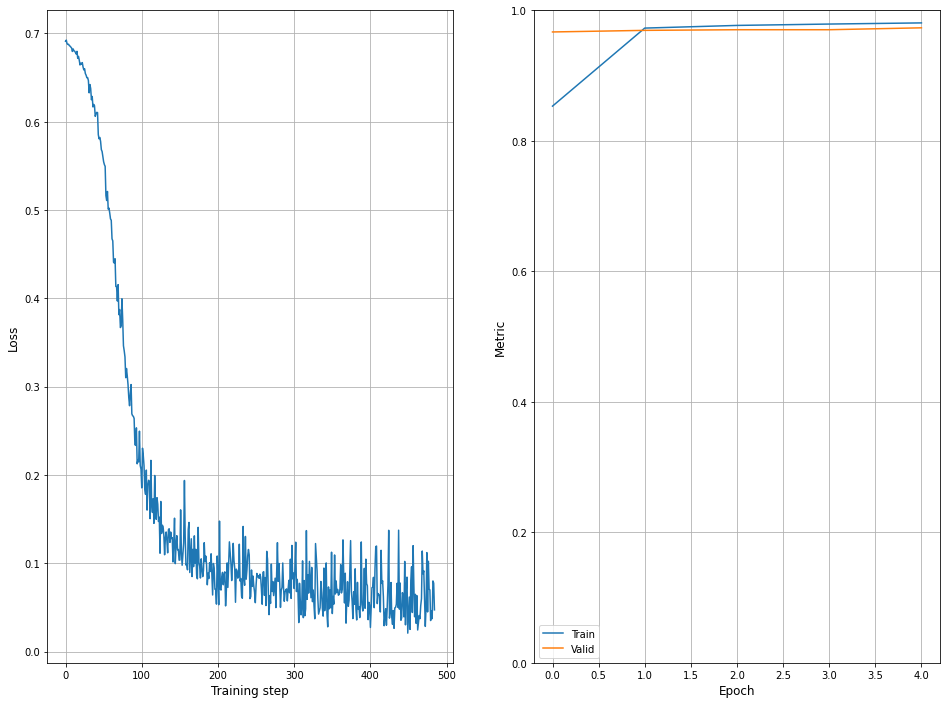

In [ ]:
classifier.plot()